In [1]:
import numpy as np
import pandas as pd
import re
import locale
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import session_info

## Challenge description

Calculate the **PIB per capita** for each of Brazil's macro-regions(Norte, Nordeste, Sul e Centro-Oeste). 
   
The final results should be reported in this example format:  
  
    
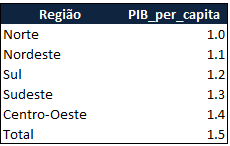
  

## Load and preview data

The data source is provided in an *excel* file ('Base de dados Case.xlsx'), divided in multiple sheets.  
Information will be loaded using `pandas`.

In [2]:
# Read data
df = pd.ExcelFile('Base de dados Case.xlsx')
df.sheet_names

['Instruções', 'Populacao_Estado', 'De_para_UF', 'PIB_municipio', 'UF_Regiao']

**Instruções** sheet only includes the description and instructions of the task. The necessary data is stored in the remaining sheets.

In [3]:
# Load each sheet
populacao_estado_df = df.parse('Populacao_Estado')
uf_df = df.parse('De_para_UF')
pib_municipio_df = df.parse('PIB_municipio')
uf_regiao = df.parse('UF_Regiao')

In [4]:
# Data frame previews
for _df in [populacao_estado_df, uf_df, pib_municipio_df, uf_regiao]:
    display(_df.head())

,Granularidade,fx_idade,Populacao
0,Brasil,Total,190755799
1,Brasil,0 a 4 anos,13806733
2,Brasil,5 a 9 anos,14967767
3,Brasil,10 a 14 anos,17167135
4,Brasil,15 a 19 anos,16986788


,Granularidade,UF,Cod_Identificacao
0,Acre,AC,12
1,Alagoas,AL,27
2,Amapa,AP,16
3,Amazonas,AM,13
4,Bahia,BA,29


,Cod_Identificacao,Municipio,PIB
0,1100015,Alta Floresta D'Oeste (RO),262077
1,1100023,Ariquemes (RO),1364694
2,1100031,Cabixi (RO),69611
3,1100049,Cacoal (RO),1186494
4,1100056,Cerejeiras (RO),222021


,Estado,Regiao
0,Rondonia,N
1,Acre,N
2,Amazonas,N
3,Roraima,N
4,Para,N


Main characteristic of each worksheet: 
- **Populacao_Estado**: contains the population values;
- **De_para_UF**: have a shared key(Granularidade) with "Populacao_Estado", and its respective ID;
- **PIB_municipio**: contains the PIB value as well as additional information in "Cod_Identificacao" and "Municipio". This information can be extracted to merge with "Cod_Identificacao" and "UF" from "De_para_UF", respectively;
- **UF_Regiao**: maps each State with its respective macro-region.

The analyis workflow will consist in the following steps:
1. Feature analysis: verify data integrity for each worksheet;
2. Normalize data: Merge values to group *PIB* and *Populacao* features;
3. Calculates the *PIB_per_capita* value;
4. Display and save results.

## 1. Feature analysis

In this step we will analyze the integrity of the data: if the data types are properly assigned, and also if there are missing or incorrect values.

### `Populacao_Estado`

In [5]:
populacao_estado_df.head()

,Granularidade,fx_idade,Populacao
0,Brasil,Total,190755799
1,Brasil,0 a 4 anos,13806733
2,Brasil,5 a 9 anos,14967767
3,Brasil,10 a 14 anos,17167135
4,Brasil,15 a 19 anos,16986788


Values for *Granularidade* includes: 26 States + DF + Brasil(Total)

In [6]:
print('Unique values for Granularidade:')
print(populacao_estado_df['Granularidade'].sort_values().unique())
print(f'Number of unique values: {populacao_estado_df["Granularidade"].nunique()}')

Unique values for Granularidade:
['Acre' 'Alagoas' 'Amapa' 'Amazonas' 'Bahia' 'Brasil' 'Ceara'
 'Distrito Federal' 'Espirito Santo' 'Goias' 'Maranhao' 'Mato Grosso'
 'Mato Grosso do Sul' 'Minas Gerais' 'Para' 'Paraiba' 'Parana'
 'Pernambuco' 'Piaui' 'Rio Grande do Norte' 'Rio Grande do Sul'
 'Rio de Janeiro' 'Rondonia' 'Roraima' 'Santa Catarina' 'Sao Paulo'
 'Sergipe' 'Tocantins']
Number of unique values: 28


There is a slight difference when summing the population values for each state and comparing with the total described in *Brasil* row.

In [7]:
# Checking number of population by Brasil vs sum of others
(
populacao_estado_df
.query('Granularidade != "Brasil"')
.groupby('Granularidade')['Populacao']
.sum().sum()
) - populacao_estado_df.groupby('Granularidade').sum().loc['Brasil']

Populacao   -3
Name: Brasil, dtype: int64

Comparing the difference of total population when summing every age range against the described total also shows some noise values.

In [8]:
# Sum of population by each age range
_total_fx_idade = (
populacao_estado_df
.query('fx_idade != "Total"')
.groupby('Granularidade', as_index=False)
[['Granularidade', 'Populacao']]
.sum()
.values[:,1]
)
# Population values where fx_idade = "Total"
_sum_fx_idade = (
populacao_estado_df
.query('fx_idade == "Total"')
[['Granularidade', 'Populacao']]
.sort_values('Granularidade')
.values[:,1]
)
# Calculate the difference for each State
_total_fx_idade - _sum_fx_idade

array([-1, -1, 1, 0, 0, 1, 2, 0, 1, -1, -2, 0, 0, -2, 0, 0, -1, 1, 2, 0,
       0, 0, -1, -1, 2, -1, 0, 0], dtype=object)

No outliers where detected.

### `De_para_UF`

In [9]:
uf_df.head()

,Granularidade,UF,Cod_Identificacao
0,Acre,AC,12
1,Alagoas,AL,27
2,Amapa,AP,16
3,Amazonas,AM,13
4,Bahia,BA,29


In [10]:
uf_df.describe(include='object')

,Granularidade,UF
count,28,28
unique,27,26
top,Distrito Federal,DF
freq,2,2


In [11]:
uf_df[uf_df.duplicated('UF', keep=False)]

,Granularidade,UF,Cod_Identificacao
6,Distrito Federal,DF,53
10,Mato Grosso,MG,51
12,Minas Gerais,MG,31
27,Distrito Federal,DF,53


There is duplicated values for **DF** and a incorrect value on the index 10.

In [12]:
# Correcting value for Mato Grosso State
uf_df.loc[10, 'UF'] = 'MT'

In [13]:
# Drop duplicated values
uf_df.drop_duplicates(inplace=True)

In [14]:
uf_df.describe(include='object').loc[['count', 'unique']]

,Granularidade,UF
count,27,27
unique,27,27


### `PIB_municipio`

In [15]:
pib_municipio_df.head()

,Cod_Identificacao,Municipio,PIB
0,1100015,Alta Floresta D'Oeste (RO),262077
1,1100023,Ariquemes (RO),1364694
2,1100031,Cabixi (RO),69611
3,1100049,Cacoal (RO),1186494
4,1100056,Cerejeiras (RO),222021


In [16]:
pib_municipio_df.shape

(5570, 3)

In [17]:
pib_municipio_df.dtypes

Cod_Identificacao     int64
Municipio            object
PIB                  object
dtype: object

*PIB* values aren't assigned with a numeric type. This happens because there is some non-numeric characters typed in some rows.

In [18]:
# Casting PIB to int
try:
    pib_municipio_df['PIB'].astype(int)
except ValueError as error:
    print('ValueError:', error)

ValueError: invalid literal for int() with base 10: '...'


In [19]:
# Checking rows with incorrect type
pib_municipio_df[pib_municipio_df['PIB'] == '...']

,Cod_Identificacao,Municipio,PIB
224,1504752,Mojuí dos Campos (PA),...
4503,4212650,Pescaria Brava (SC),...
4605,4220000,Balneário Rincão (SC),...
4923,4314548,Pinto Bandeira (RS),...
5160,5006275,Paraíso das Águas (MS),...


In [20]:
# Calculate the percentage of incorrect values
_missing_percent = (
    pib_municipio_df[pib_municipio_df['PIB'] == '...'].shape[0] 
    / pib_municipio_df.shape[0] 
    * 100
)
print(f'Percentage of "missing" values: {_missing_percent:.2f}%')
del _missing_percent

Percentage of "missing" values: 0.09%


There is two options to deal with this problem:  
1. Impute values, like the mean of the respective State;
2. Remove the observations, since it represents a small percentage of the dataset (0.09%).  

We will follow with the option 2, removing these observations.

In [21]:
# alternative 1: remove these observations
# _condition = pib_municipio_df[pib_municipio_df['PIB'] == '...'].index
# pib_municipio_df.drop(_condition)

# alternative 2: parse with pd.to_numeric(), invalid rows will be replaced by null values
pib_municipio_df['PIB'] = pd.to_numeric(pib_municipio_df['PIB'], errors='coerce')
print('Number of NaNs after parsing:', pib_municipio_df['PIB'].isna().sum())

Number of NaNs after parsing: 5


In [22]:
# Drop null values
pib_municipio_df.dropna(inplace=True)

Now let's extract information to create the share keys for "De_para_UF" dataframe.  
- The first two digits of "Cod_Identificacao" is from the UF id.
- Every UF value is written between parentheses at each value of "Municipio".

In [23]:
# First two digits for Cod_Identificacao, as string type to describe as a category
pib_municipio_df['Cod_Identificacao_uf'] = pib_municipio_df['Cod_Identificacao'].apply(lambda x : str(int(x//1e5)))

In [24]:
# Extract UF acronym between () in "Municipio"
pib_municipio_df['UF'] = pib_municipio_df['Municipio'].apply(lambda x : re.findall(r'\((.*)\)', x)[0])

In [25]:
pib_municipio_df.head()

,Cod_Identificacao,Municipio,PIB,Cod_Identificacao_uf,UF
0,1100015,Alta Floresta D'Oeste (RO),262077.0,11,RO
1,1100023,Ariquemes (RO),1364694.0,11,RO
2,1100031,Cabixi (RO),69611.0,11,RO
3,1100049,Cacoal (RO),1186494.0,11,RO
4,1100056,Cerejeiras (RO),222021.0,11,RO


In [26]:
# Checking
pib_municipio_df[['Cod_Identificacao_uf', 'UF']].describe(include='all')

,Cod_Identificacao_uf,UF
count,5565,5565
unique,27,27
top,31,MG
freq,853,853


In [27]:
# plt.figure(figsize=(16,5))
# sns.boxplot(
#     data=pib_municipio_df,
#     y='PIB',
#     x='UF')
# plt.title('PIB por UF', size=18, loc='left', pad=20)
# plt.show()

### `UF_Regiao`

There is nothing to modify in this dataframe.

In [28]:
uf_regiao.head()

,Estado,Regiao
0,Rondonia,N
1,Acre,N
2,Amazonas,N
3,Roraima,N
4,Para,N


In [29]:
uf_regiao.shape

(27, 2)

In [30]:
uf_regiao.describe()

,Estado,Regiao
count,27,27
unique,27,5
top,Rondonia,NE
freq,1,9


## 2. Normalize data

### Create normalized dataframe from `Populacao_Estado`

In [31]:
# Selecting Total will be more computationally efficient than grouping and summing values
norm_df = (
    populacao_estado_df
    .query('fx_idade == "Total"')
    .drop(columns='fx_idade')
    .sort_values('Granularidade')
    .reset_index(drop=True)
)

norm_df.head(6)

,Granularidade,Populacao
0,Acre,733559
1,Alagoas,3120494
2,Amapa,669526
3,Amazonas,3483985
4,Bahia,14016906
5,Brasil,190755799


In [32]:
# Store and remove Brasil row from norm_df
brasil_population = norm_df[norm_df['Granularidade']=='Brasil']['Populacao'].values[0]
norm_df.dropna(inplace=True)
print(f'Brazilian total population: {brasil_population}')

Brazilian total population: 190755799


### Merge with `uf_df`, using *Granularidade* key

In [33]:
norm_df = pd.merge(
    left=norm_df,
    right=uf_df,
    on='Granularidade',
    how='left'
)

norm_df.head(6)

,Granularidade,Populacao,UF,Cod_Identificacao
0,Acre,733559,AC,12.0
1,Alagoas,3120494,AL,27.0
2,Amapa,669526,AP,16.0
3,Amazonas,3483985,AM,13.0
4,Bahia,14016906,BA,29.0
5,Brasil,190755799,NaN,NaN


In [34]:
# Drop NaNs
norm_df.dropna(inplace=True)

In [35]:
norm_df.describe(include='object').loc[['count', 'unique']]

,Granularidade,UF
count,27,27
unique,27,27


### Merge with `pib_municipio_df` using *UF* key

In [36]:
# Group PIB values by UF
pib_municipio_grouped_df = pib_municipio_df.groupby(['UF', 'Cod_Identificacao_uf'], as_index=False)['PIB'].sum()
pib_municipio_grouped_df.head()

,UF,Cod_Identificacao_uf,PIB
0,AC,12,8342356.0
1,AL,27,27133035.0
2,AM,13,60877125.0
3,AP,16,8237794.0
4,BA,29,154419544.0


In [37]:
# Apply merge
norm_df = pd.merge(
    left=norm_df,
    right=pib_municipio_grouped_df,
    how='left',
    on='UF'
)

norm_df.head()

,Granularidade,Populacao,UF,Cod_Identificacao,Cod_Identificacao_uf,PIB
0,Acre,733559,AC,12.0,12,8342356.0
1,Alagoas,3120494,AL,27.0,27,27133035.0
2,Amapa,669526,AP,16.0,16,8237794.0
3,Amazonas,3483985,AM,13.0,13,60877125.0
4,Bahia,14016906,BA,29.0,29,154419544.0


In [38]:
# Checking if Cod_Identificacao matches
print('Checking if merged values from Cod_Identificacao matches.')
all(norm_df['Cod_Identificacao'] == norm_df['Cod_Identificacao_uf'].astype(float))

Checking if merged values from Cod_Identificacao matches.


True

In [39]:
# Drop duplicated column
norm_df.drop(columns='Cod_Identificacao_uf', inplace=True)

### Merge with `uf_regiao` using *Granularidade* key

In [40]:
norm_df = pd.merge(
    left=norm_df,
    right=uf_regiao,
    how='left',
    left_on='Granularidade',
    right_on='Estado',
    left_index=False
)

norm_df.head()

,Granularidade,Populacao,UF,Cod_Identificacao,PIB,Estado,Regiao
0,Acre,733559,AC,12.0,8342356.0,Acre,N
1,Alagoas,3120494,AL,27.0,27133035.0,Alagoas,NE
2,Amapa,669526,AP,16.0,8237794.0,Amapa,N
3,Amazonas,3483985,AM,13.0,60877125.0,Amazonas,N
4,Bahia,14016906,BA,29.0,154419544.0,Bahia,NE


### Reorder and map values for *Regiao*

In [41]:
# Reorder columns, dropping duplicated column "Granularidade"
norm_df = norm_df[[
    'Estado',
    'UF',
    'Regiao',
    'Cod_Identificacao',
    'Populacao',
    'PIB',
]]

In [42]:
# Map and replace values for "Regiao"
norm_df['Regiao'] = norm_df['Regiao'].map({
    'N' : 'Norte',
    'NE' : 'Nordeste',
    'S' : 'Sul',
    'SE' : 'Sudeste',
    'CO' : 'Centro-Oeste',
})

## 3. Calculating `PIB_per_capita`

### Add `PIB_per_capita` feature

In [43]:
norm_df['PIB_per_capita'] = norm_df['PIB'] / norm_df['Populacao']

norm_df['PIB_per_capita'].describe()

count    27.000000
mean     17.171417
std      10.123858
min       7.043516
25%      11.032707
50%      14.737979
75%      20.431935
max      56.095380
Name: PIB_per_capita, dtype: float64

### Visualizing the distribution of PIB and PIB_per_capita for each UF.

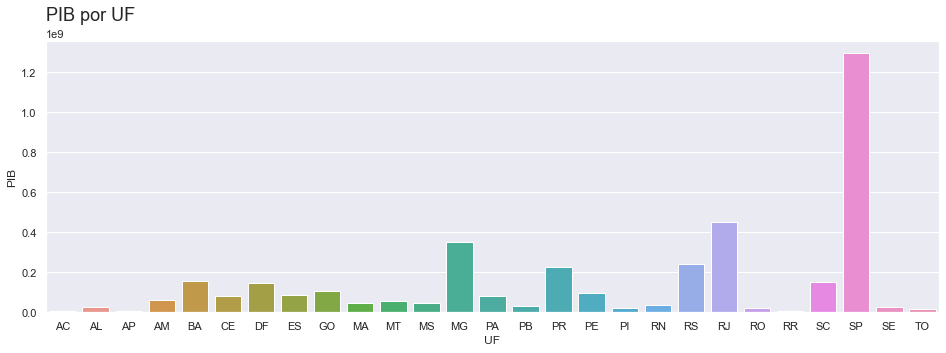

In [44]:
plt.figure(figsize=(16,5))
sns.barplot(data=norm_df, x='UF', y='PIB')
plt.title('PIB por UF', size=18, loc='left', pad=20)
plt.show()

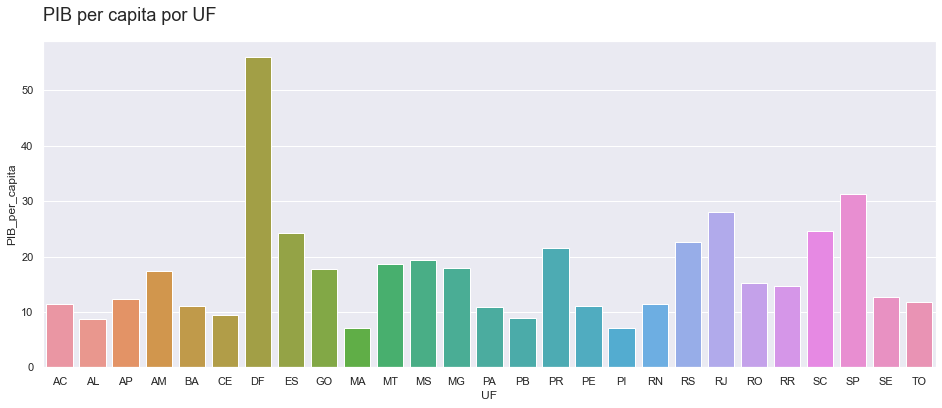

In [45]:
plt.figure(figsize=(16,6))
sns.barplot(data=norm_df, x='UF', y='PIB_per_capita')
plt.title('PIB per capita por UF', size=18, loc='left', pad=20)
plt.show()

It seems that the `PIB_per_capita` data is reduced in the order of 1000.  
By checking the total sum of PIB by cities, we can verify that the value is actually lower.

In [46]:
pib_municipio_df['PIB'].sum() / 1e12 # trillion

0.003885846972

In [47]:
print('São Paulo(city) data:')
pib_municipio_df.sort_values('PIB', ascending=False).iloc[0,:]

São Paulo(city) data:


Cod_Identificacao              3550308
Municipio               São Paulo (SP)
PIB                        450491988.0
Cod_Identificacao_uf                35
UF                                  SP
Name: 3829, dtype: object

Taking the city of São Paulo as a sample, we found that the PIB value of 450,491,988 is the reference for the year 2010 [(Evolução do Produto Interno Bruto (PIB) table)](https://pt.wikipedia.org/wiki/Economia_da_cidade_de_S%C3%A3o_Paulo) confirming that the PIB value is in the magnitude of R$ 1000.  

In [48]:
# Calculate total PIB multiplied by 1000
total_pib = round(norm_df['PIB'].sum() * 1000 / brasil_population, 2)
norm_df['PIB_per_capita'] = norm_df['PIB_per_capita'] * 1000

In [49]:
# Dataframe with results from PIB per capita for each Macro region
results_df = (
    norm_df
    .groupby('Regiao', as_index=False)
    ['PIB_per_capita']
    .sum().round(1)
    .sort_values('Regiao')
    .append({
        'PIB_per_capita' : total_pib,
        'Regiao' : 'Total',
    }, ignore_index=True)
)
# Reorder rows
results_df = results_df.reindex([2,1,4,3,0,5]).reset_index(drop=True)

## Reporting results

Results will be displayed in currency format(BRL) for easy visualization, and exported as a `csv` file in the directory **data**.

In [50]:
# Display results with formatted values
display_df = results_df.copy()
# Set locale for BR currency
locale.setlocale( locale.LC_ALL, 'pt_BR.UTF-8' )
# Apply transformation to currency
display_df['PIB_per_capita'] = display_df['PIB_per_capita'].apply(
    lambda x : locale.currency(x, grouping=True))
# Show dataframe
display(display_df)

,Regiao,PIB_per_capita
0,Norte,"R$ 93.954,40"
1,Nordeste,"R$ 87.421,70"
2,Sul,"R$ 68.723,80"
3,Sudeste,"R$ 101.698,70"
4,Centro-Oeste,"R$ 111.829,70"
5,Total,"R$ 20.370,79"


In [51]:
# Export result to csv
results_df.to_csv('data/results.csv', index=False)

In [52]:
# Libraries versions used in this notebook
session_info.show()